In [2]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

/home/leonaire/anaconda3/envs/ecole/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read dataset

In [52]:
import pickle as pkl
import json
import ast
"""
param:path of folder
return :data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y
"""
def load_data(path = "DataSet/"):
    split = [0.75,0.15,0.15]
    path_set = os.listdir(path)
    data_train_X = []
    data_validation_X = []
    data_test_X = []
    data_train_Y = []
    data_validation_Y = []
    data_test_Y = []

    index = 0
    nb_total = len(path_set)
    for filename in path_set:
        #read features of constraints 
        cons_file = open(path+filename+"/constraints_features.json","rb")
        data = json.load(cons_file)
        data_cons = np.array(data["values"])

        #read features of variables 
        var_file = open(path+filename+"/variables_features.json","rb")
        data = json.load(var_file)
        data_var = np.array(data["values"])

        #read label 
        label_file = open(path+filename+"/label.json","rb")
        data = json.load(label_file)
        bestSol = data["Best_Solution"]
        bestSol = ast.literal_eval(bestSol)
        data_label = np.array(list(bestSol.values()))

        #read edge
        edges_file = open(path+filename+"/edges_features.json","rb")
        data_cons = np.hstack((data_cons,np.zeros((data_cons.shape[0],19))))
        data_var = np.hstack((np.zeros((data_var.shape[0],5)),data_var))
        matrix_A = np.vstack((data_cons,data_var))
    #     print(data_cons.shape)
    #     print(data_var.shape)
    #     print(matrix_A.shape)
        if index < nb_total * split[0]:
#             print(filename)
            data_train_X.append(matrix_A)
            data_train_Y.append(data_label)
        elif index < nb_total * split[1]:
            data_validation_X.append(matrix_A)
            data_validation_Y.append(data_label)
        else:
            data_test_X.append(matrix_A)
            data_test_Y.append(data_label)
        index += 1
    return     np.array(data_train_X),np.array(data_train_Y),np.array(data_validation_X),np.array(data_validation_Y),np.array(data_test_X),np.array(data_test_Y)
data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y = load_data()

# GCN






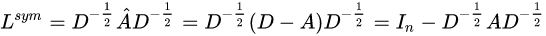

In [119]:
class MLP(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(GCNConv, self).__init__()
        self.linear = nn.Linear(in_channel, in_channel)
        self.activate = nn.Relu(in_channel, out_channel)
        
    def forward(self, x, A):
        x = self.linear(x)
        x = A.mm(x)
        x = self.activate(x)
        return x
        
class Net(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Net,self).__init__()
        self.mlp = MLP(in_channel, out_channel)
        self.linear = nn.Linear(out_channel, out_channel)
        self.activate = nn.Relu(out_channel, out_channel)
        
    
    def forward(self, x, edge_index):
        x = self.linear(x)
        x = edges_features.mm(x)
        x = self.activate(x)
        
        return x
    
# class Output(nn.Module):
#     def 
    